## ML - II (Assignment 2 and assignment 3)

## Non Linear classification based on SVM and Sparse Random Projections

#### All the analysis has been done in breast cancer dataset

### Importing libraries

In [1]:
# All SVM and kernel dependencies
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, validation_curve
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from IPython.display import display, Math, Latex
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import f1_score, precision_score, confusion_matrix, recall_score, accuracy_score,classification_report,roc_auc_score
from sklearn.metrics import fbeta_score
from sklearn.metrics import make_scorer
from sklearn.random_projection import johnson_lindenstrauss_min_dim
from sklearn.random_projection import SparseRandomProjection
from sklearn.svm import LinearSVC

### The data souce is collected from datasets package and the data is about breast cancer

In [2]:
#Load dataset
cancer = datasets.load_breast_cancer()

# Convert to df
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df.head(5)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Let's check the data by EDA and if an cleaning is required or not

In [3]:
print("The missing values in data columns :")
print(df.isna().sum())

The missing values in data columns :
mean radius                0
mean texture               0
mean perimeter             0
mean area                  0
mean smoothness            0
mean compactness           0
mean concavity             0
mean concave points        0
mean symmetry              0
mean fractal dimension     0
radius error               0
texture error              0
perimeter error            0
area error                 0
smoothness error           0
compactness error          0
concavity error            0
concave points error       0
symmetry error             0
fractal dimension error    0
worst radius               0
worst texture              0
worst perimeter            0
worst area                 0
worst smoothness           0
worst compactness          0
worst concavity            0
worst concave points       0
worst symmetry             0
worst fractal dimension    0
dtype: int64


##### Let's prepare for higher dimensionality mapping i.e Kernelization

In [4]:
# Split to X and y
X = cancer.data
y = cancer.target

# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(
                                    X,y, test_size=0.3, random_state=330)

#### Our aim is find that function that linearly maps the points in higher dimensional space perfectly

 **$$ K(x,y) = <φ(x),φ(y)> $$**
 
*The K value which follows Mercer's rule with the function φ(x)*

### Normalizing values

Fitting the values with standard scaler for bringing all the axis in one scale

In [5]:
# Scaling the values
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Training The model


#### The concept used  here is SVM with three types of kernels:

##### 1.  Gaussian Kernels
          Gaussian kernels are used to map to infinite dimensional space

\begin{equation}
k(x,x') = e^{\frac{-||x - x'||}{2 * \sigma ^2}}
\end{equation}

##### 2.  Polynomial Kernels
          Polynomial kernels can be used to find projections of data in higher dimensional space to find linearity
          

\begin{equation}
k(x,x') = (1 + X^T*X')^d
\end{equation}

##### 3.  Linear Kernels
          Linear kernels helps in training the data by the simple notion of finding weight


\begin{equation}
k(x,x') = (1 + X^T*X')
\end{equation}

#### Sparse Random Projections
 It is based on Johnson-Lindenstrauss lemma, which states that if points in a vector space are of sufficiently high dimension, then they may be projected into a suitable lower-dimensional space in a way which approximately preserves the distances between the points.
 

\begin{equation}
k = O(\xi^-2*log(1/\xi))
\end{equation}

#### This class contains all the necessary dependencies to run the SVM kernel and sparse projections

In [9]:
##***** The class is used for classifying in SVC kernel with support vector machines*****
class classification:
  
 def __init__(self, X, y):
    
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    self.labels = np.unique(y).tolist()

 def confusion_matrix(self):
    #"For plotting matrix plot in kernel"
    cm = confusion_matrix(self.y_test, self.pred, self.labels)
    print(" The confusion matrix is :", '\n' , cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + self.labels)
    ax.set_yticklabels([''] + self.labels)
    plt.xlabel('$Predicted$')
    plt.ylabel('$True$')
    plt.show()
    
 def calc_metrics_class(self):
    #"For getting matrix of all values"
    precision = precision_score(self.pred, self.y_test)
    recall = recall_score(self.pred,self.y_test)
    f1 = f1_score(self.pred,self.y_test)
    accuracy = accuracy_score(self.pred,self.y_test)
    roc = roc_auc_score(self.y_test, self.pred)
    print("The precision for the model is :", precision, '\n', "The recall for the model is : ", recall, '\n'
          , "The f1 score of the model is :", f1, '\n', 
          "The accuracy of the model is : ", accuracy, '\n', "The ROC curve of the model is : ", roc )
    # print classification report 
    print(classification_report(self.y_test,self.pred))
 
 def f2_scorer(self,y_true, y_pred):
    #"For giving it to model as best criterion param"
    y_true, y_pred, = np.array(y_true), np.array(y_pred)
    return fbeta_score(y_true, y_pred, beta=2, pos_label=0, average='binary')
  
 def validation_plot_rbf(self,kernel):
    #"For validating and plotting"
    l = len(self.gamma)
    kfold = 5
    self.f2 = make_scorer(self.f2_scorer,greater_is_better=True)
    
    train_scores, valid_scores = validation_curve(kernel, X_train, y_train,'gamma',
                                                  self.gamma, cv=KFold(n_splits=5,random_state=7), 
                                                  scoring = self.f2,verbose=True)
    train_scores_poly_recall = pd.DataFrame(data=train_scores, 
                                        index=np.arange(0, l), 
                                        columns=np.arange(0,kfold)) 
    valid_scores_poly_recall = pd.DataFrame(data=valid_scores, 
                                        index=np.arange(0, l), 
                                        columns=np.arange(0,kfold))
    
    plt.plot(self.gamma, train_scores_poly_recall.mean(axis=1), label='training')
    plt.plot(self.gamma, valid_scores_poly_recall.mean(axis=1), label='test')
    plt.xlabel('gamma')
    plt.ylabel('F2 - Score')
    plt.title('SVM with RBF Kernel')
    plt.legend()
  
 def validation_plot_polynomial(self,kernel):
    #"For validating and plotting"
    l = len(self.degrees)
    kfold = 5
    self.f2 = make_scorer(self.f2_scorer,greater_is_better=True)
    
    train_scores, valid_scores = validation_curve(kernel, X_train, y_train,'degree',
                                                  self.degrees, cv=KFold(n_splits=5,random_state=7), 
                                                  scoring = self.f2,verbose=True)
    train_scores_poly_recall = pd.DataFrame(data=train_scores, 
                                        index=np.arange(0, l), 
                                        columns=np.arange(0,kfold)) 
    valid_scores_poly_recall = pd.DataFrame(data=valid_scores, 
                                        index=np.arange(0, l), 
                                        columns=np.arange(0,kfold))
    
    plt.plot(self.degrees, train_scores_poly_recall.mean(axis=1), label='training')
    plt.plot(self.degrees, valid_scores_poly_recall.mean(axis=1), label='test')
    plt.xlabel('degree')
    plt.ylabel('F2 - Score')
    plt.title('SVM with Polynomial Kernel')
    plt.legend()

 def rbf_kernel_svc(self):
 #"RBF Kernel"
      print('Performing modelling for RBF Kernel using SVM')
      self.f2 = make_scorer(self.f2_scorer,greater_is_better=True)
      self.gamma = [1,0.1,0.01,0.001]
      param_grid = {
             'C': [0.1,1, 10,100],
             'gamma': self.gamma,
             'kernel': ['rbf'],
             'max_iter':[100]}
      rbf = SVC()
      grid_model = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,cv=5, n_jobs=-1,scoring=self.f2)  
      grid_model.fit(self.X_train,self.y_train)
      print("Best parameters =", grid_model.best_params_)
      model_clf = rbf.set_params(**grid_model.best_params_)
      model_clf.fit(self.X_train, self.y_train)
      self.pred = model_clf.predict(self.X_test)
      self.calc_metrics_class()
      self.confusion_matrix()
      self.validation_plot_rbf(rbf)
        
        
 def polynomial_kernel_svc(self):
    #"Polynomial Kernel"
      print('Performing modelling for Polynomial Kernel using SVM')
      self.f2 = make_scorer(self.f2_scorer,greater_is_better=True)
      self.degrees = [2,4,6,10,22]
      param_grid = {
             'C': [0.1,1, 10,100],
             'degree': self.degrees,
             'kernel': ['poly'],
             'max_iter':[200]}
      polynomial = SVC()
      grid_model = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3,cv=5, n_jobs=-1,scoring=self.f2)  
      grid_model.fit(self.X_train,self.y_train)
      print("Best parameters =", grid_model.best_params_)
      model_clf = polynomial.set_params(**grid_model.best_params_)
      model_clf.fit(self.X_train, self.y_train)
      self.pred = model_clf.predict(self.X_test)
      self.calc_metrics_class()
      self.confusion_matrix()
      self.validation_plot_polynomial(polynomial)
    
 def linear_svc(self,feature_len):
        # Linear kernel
        model = LinearSVC()
        model.fit(self.X_train, self.y_train)
        baseline = metrics.accuracy_score(model.predict(self.X_test), self.y_test)
        accuracies = []
        dims = np.int32(np.linspace(2, feature_len, 20))
       
       # Loop over the projection sizes, k
        for dim in dims:
            # Create random projection
            sp = SparseRandomProjection(n_components = dim)
            X = sp.fit_transform(self.X_train)

            # Train classifier of your choice on the sparse random projection
            model = LinearSVC()
            model.fit(X, self.y_train)

            # Evaluate model and update accuracies
            test = sp.transform(self.X_test)
            accuracies.append(metrics.accuracy_score(model.predict(test), self.y_test))
            
        #Create figure
        plt.figure()
        plt.xlabel(r'Number of dimensions k')
        plt.ylabel(r'Accuracy')
        plt.xlim([1, feature_len])
        plt.ylim([0, 1])
        # Plot baseline and random projection accuracies
        plt.plot(dims, [baseline] * len(accuracies), color = "r",label = 'baseline')
        plt.plot(dims, accuracies,color="b",label = 'accuracy with dimensions')
        plt.legend()
        plt.show()

Performing modelling for RBF Kernel using SVM
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:    9.0s finished


Best parameters = {'C': 1, 'gamma': 0.001, 'kernel': 'rbf', 'max_iter': 100}
The precision for the model is : 0.9436619718309859 
 The recall for the model is :  0.9436619718309859 
 The f1 score of the model is : 0.9436619718309859 
 The accuracy of the model is :  0.9298245614035088 
 The ROC curve of the model is :  0.9253193580085163
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        43
           1       0.94      0.94      0.94        71

   micro avg       0.93      0.93      0.93       114
   macro avg       0.93      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114

 The confusion matrix is : 
 [[39  4]
 [ 4 67]]


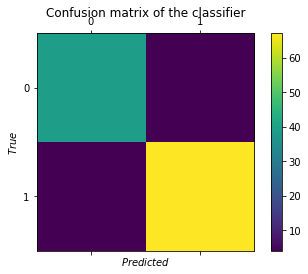

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.1s finished


Performing modelling for Polynomial Kernel using SVM
Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.3s finished


Best parameters = {'C': 0.1, 'degree': 2, 'kernel': 'poly', 'max_iter': 200}
The precision for the model is : 1.0 
 The recall for the model is :  0.8987341772151899 
 The f1 score of the model is : 0.9466666666666668 
 The accuracy of the model is :  0.9298245614035088 
 The ROC curve of the model is :  0.9069767441860466
              precision    recall  f1-score   support

           0       1.00      0.81      0.90        43
           1       0.90      1.00      0.95        71

   micro avg       0.93      0.93      0.93       114
   macro avg       0.95      0.91      0.92       114
weighted avg       0.94      0.93      0.93       114

 The confusion matrix is : 
 [[35  8]
 [ 0 71]]


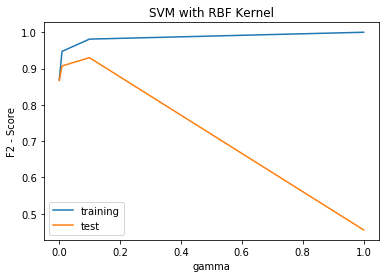

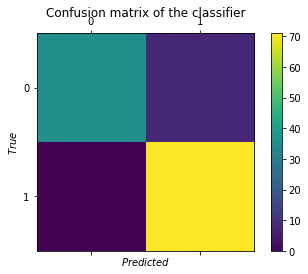

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.2s finished


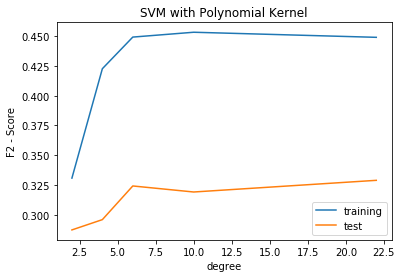

In [7]:
p1 = classification(X,y)
p1.rbf_kernel_svc()
p1.polynomial_kernel_svc()

##### Now let's check with sparse dimensions whats the accuracy score

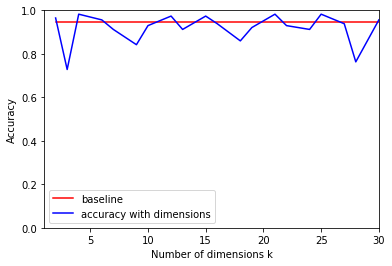

In [10]:
p1.linear_svc(len(df.columns))

- We see a heavy deviation of projections with baseline and as we approach towards higher dimensions we reach stability
- Overall there has been improvement in accuracy when compared to baseline model thus verifying Johnson-Lindenstraus Lemma


In [ ]:
print("Professor Nagler is the Best")